# Train LSTM network using Keypoint Features

## Import libraries

In [1]:
# Basic functions
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils
import vidutils

## Create Training and Test Sets

### Load training data
Choose between using synthetic data, real data or both. 

Usage example: If only real data is to be used, set `real_data` to `True` and `syn_data` to `False`.

In [2]:
### --------------------------------------------
# Choose datasets to use
real_data = True
syn_data = False
### --------------------------------------------

X_paths = [] # paths of segment folders
y = [] # designated label

if real_data:
    # Specify directories
    frame_folder = "./data/frames"
    
    # Construct X = folder names, y = the label
    vf_list = []
    for f in os.listdir(frame_folder):
        if not f.startswith('.'):
            vf_list.append(f)
    
    for vf_folder in vf_list:
        # Create path to video
        vf_path = os.path.join(frame_folder, vf_folder)
        print("Current Video: "+ vf_folder)

        # Get individual segment folder
        segfolder_list = os.listdir(vf_path)

        # Check every segment folder
        for seg_folder in segfolder_list:

            if not seg_folder.startswith('.'):
                x_path = os.path.join(vf_path, seg_folder)
                X_paths.append(x_path + '/features.npz')

                # Extract class label from folder name
                label = int(seg_folder.split("_")[2])
                y.append(label)
        
if syn_data:
    # define synthetic data directory
    output_dir = './synthetic_data/output'
    output_list = os.listdir(output_dir)

    for output_folder in output_list:
        if output_folder.startswith('vid'):
            x_path = output_dir + '/' + output_folder
            X_paths.append(x_path)

            # Extract class label from folder name
            params = re.findall(r'\d+', output_folder)
            label = int( (int(params[3]) - 1) / 100)
            y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


In [3]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 54, 2: 49, 4: 50, 5: 51, 8: 52, 9: 52, 0: 48, 3: 50, 6: 48, 7: 50})

In [4]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


### Conversion to Pytorch Dataset
Set seeds for reproducibility and produce pytorch tensor for training.

In [5]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

Definition of dataset class and normalization function

In [6]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features (different based on synthetic or real)
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

# Define normalization function
class norm_with_saved(object):
    """
    Rescale each feature by subtracting mean and dividing by SD over all subjects
    IMPORTANT: Calculate saved_mean and saved_std first.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [7]:
# Define Transformer 
transformer = transforms.Compose([
    transforms.ToTensor() 
])

In [8]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [9]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

### Define Data Loader  

Data Loader for extracting batches from the Pytorch Dataset during model training

In [10]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [11]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

In [12]:
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


## Model Definition 
Define LSTM architecture and optimizer settings.

In [13]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        return output     

Choose between regression or classification model and select type of loss.

Modify `loss_fn` and `weight_path` to choose the most appropriate loss function and save the results in a directory of your choice.

In [14]:
### --------------------------------------------
# Choose whether to use classification model or regression model
classif_model = True
reg_model = False
### --------------------------------------------
assert (classif_model != reg_model), print("ERROR: Choose one model only")

# Define Loss Function
if classif_model:
    loss_fn = nn.CrossEntropyLoss(reduction="sum")
    weight_path = "./models/weights_kpf_classifier.pt"
    num_class = 10

if reg_model:
    # choose between L1 and MSE
    #loss_fn = nn.L1Loss(reduction="sum")
    loss_fn = nn.MSELoss(reduction="sum")
    weight_path = "./models/weights_kpf_regressor.pt"
    num_class = 1


# RNN Model Parameters
model_params = {
    "num_classes": num_class,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)

In [15]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,1,10] for classification and [1,1,1] for regression

torch.Size([1, 1, 10])


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    cuda_available = True
else:
    device = torch.device("cpu")
    cuda_available = False

# Print Model Params
model = model.to(device)
model

SyncRNN(
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
)

Define optimizer settings

In [17]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 3e-3) 

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

In [18]:
# Define Training Parameters
train_params = {
    "num_epochs": 200, 
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": weight_path,
    "cuda_available": cuda_available
}

## Model Training  

Train network and display train/test accuracies.

In [19]:
# train model
if classif_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_class(model, train_params)
if reg_model:
    trained_model, loss_hist, metric_hist = trainutils.train_model_reg(model, train_params)

Epoch 0/199, current_lr=0.003



Saved best model weights
Train Loss: 2.344091, Dev Loss: 2.322257, Accuracy: 5.88
----------
Epoch 1/199, current_lr=0.003



Saved best model weights
Train Loss: 2.328761, Dev Loss: 2.302235, Accuracy: 11.76
----------
Epoch 2/199, current_lr=0.003



Train Loss: 2.321369, Dev Loss: 2.306009, Accuracy: 3.92
----------
Epoch 3/199, current_lr=0.003



Saved best model weights
Train Loss: 2.308566, Dev Loss: 2.297960, Accuracy: 9.80
----------
Epoch 4/199, current_lr=0.003



Train Loss: 2.310083, Dev Loss: 2.299194, Accuracy: 9.80
----------
Epoch 5/199, current_lr=0.003



Train Loss: 2.311662, Dev Loss: 2.300640, Accuracy: 9.80
----------
Epoch 6/199, current_lr=0.003



Train Loss: 2.308539, Dev Loss: 2.311032, Accuracy: 5.88
----------
Epoch 7/199, current_lr=0.003



Train Loss: 2.307344, Dev Loss: 2.304648, Accuracy: 11.76
----------
Epoch 8/199, current_lr=0.003



Train Loss: 2.311143, Dev Loss: 2.311015, Accuracy: 7.84
----------
Epoch 9/199, current_lr=0.003



Epoch    10: reducing learning rate of group 0 to 2.1000e-03.
Loading best model weights
Train Loss: 2.310158, Dev Loss: 2.305942, Accuracy: 11.76
----------
Epoch 10/199, current_lr=0.0021



Saved best model weights
Train Loss: 2.309658, Dev Loss: 2.297052, Accuracy: 17.65
----------
Epoch 11/199, current_lr=0.0021



Saved best model weights
Train Loss: 2.304292, Dev Loss: 2.296331, Accuracy: 13.73
----------
Epoch 12/199, current_lr=0.0021



Train Loss: 2.307287, Dev Loss: 2.307216, Accuracy: 7.84
----------
Epoch 13/199, current_lr=0.0021



Saved best model weights
Train Loss: 2.305906, Dev Loss: 2.296054, Accuracy: 7.84
----------
Epoch 14/199, current_lr=0.0021



Train Loss: 2.306177, Dev Loss: 2.299185, Accuracy: 13.73
----------
Epoch 15/199, current_lr=0.0021



Train Loss: 2.306997, Dev Loss: 2.303740, Accuracy: 9.80
----------
Epoch 16/199, current_lr=0.0021



Train Loss: 2.306397, Dev Loss: 2.296157, Accuracy: 11.76
----------
Epoch 17/199, current_lr=0.0021



Train Loss: 2.305024, Dev Loss: 2.301747, Accuracy: 11.76
----------
Epoch 18/199, current_lr=0.0021



Train Loss: 2.306735, Dev Loss: 2.300396, Accuracy: 13.73
----------
Epoch 19/199, current_lr=0.0021



Epoch    20: reducing learning rate of group 0 to 1.4700e-03.
Loading best model weights
Train Loss: 2.305099, Dev Loss: 2.301227, Accuracy: 13.73
----------
Epoch 20/199, current_lr=0.0014699999999999997



Train Loss: 2.302419, Dev Loss: 2.297983, Accuracy: 15.69
----------
Epoch 21/199, current_lr=0.0014699999999999997



Train Loss: 2.301651, Dev Loss: 2.308840, Accuracy: 5.88
----------
Epoch 22/199, current_lr=0.0014699999999999997



Train Loss: 2.303650, Dev Loss: 2.303016, Accuracy: 7.84
----------
Epoch 23/199, current_lr=0.0014699999999999997



Train Loss: 2.302525, Dev Loss: 2.298847, Accuracy: 13.73
----------
Epoch 24/199, current_lr=0.0014699999999999997



Train Loss: 2.301017, Dev Loss: 2.306957, Accuracy: 9.80
----------
Epoch 25/199, current_lr=0.0014699999999999997



Epoch    26: reducing learning rate of group 0 to 1.0290e-03.
Loading best model weights
Train Loss: 2.302804, Dev Loss: 2.307463, Accuracy: 9.80
----------
Epoch 26/199, current_lr=0.0010289999999999997



Train Loss: 2.303915, Dev Loss: 2.305248, Accuracy: 7.84
----------
Epoch 27/199, current_lr=0.0010289999999999997



Train Loss: 2.299380, Dev Loss: 2.303928, Accuracy: 9.80
----------
Epoch 28/199, current_lr=0.0010289999999999997



Train Loss: 2.302106, Dev Loss: 2.300676, Accuracy: 11.76
----------
Epoch 29/199, current_lr=0.0010289999999999997



Train Loss: 2.300811, Dev Loss: 2.299338, Accuracy: 9.80
----------
Epoch 30/199, current_lr=0.0010289999999999997



Train Loss: 2.299570, Dev Loss: 2.300312, Accuracy: 13.73
----------
Epoch 31/199, current_lr=0.0010289999999999997



Epoch    32: reducing learning rate of group 0 to 7.2030e-04.
Loading best model weights
Train Loss: 2.298172, Dev Loss: 2.308166, Accuracy: 5.88
----------
Epoch 32/199, current_lr=0.0007202999999999998



Saved best model weights
Train Loss: 2.303919, Dev Loss: 2.294325, Accuracy: 15.69
----------
Epoch 33/199, current_lr=0.0007202999999999998



Train Loss: 2.300866, Dev Loss: 2.306292, Accuracy: 11.76
----------
Epoch 34/199, current_lr=0.0007202999999999998



Train Loss: 2.302168, Dev Loss: 2.299242, Accuracy: 11.76
----------
Epoch 35/199, current_lr=0.0007202999999999998



Train Loss: 2.302711, Dev Loss: 2.306016, Accuracy: 9.80
----------
Epoch 36/199, current_lr=0.0007202999999999998



Train Loss: 2.300543, Dev Loss: 2.307826, Accuracy: 7.84
----------
Epoch 37/199, current_lr=0.0007202999999999998



Train Loss: 2.303319, Dev Loss: 2.297565, Accuracy: 13.73
----------
Epoch 38/199, current_lr=0.0007202999999999998



Epoch    39: reducing learning rate of group 0 to 5.0421e-04.
Loading best model weights
Train Loss: 2.301833, Dev Loss: 2.300386, Accuracy: 9.80
----------
Epoch 39/199, current_lr=0.0005042099999999998



Train Loss: 2.302083, Dev Loss: 2.300049, Accuracy: 11.76
----------
Epoch 40/199, current_lr=0.0005042099999999998



Saved best model weights
Train Loss: 2.299274, Dev Loss: 2.290349, Accuracy: 15.69
----------
Epoch 41/199, current_lr=0.0005042099999999998



Train Loss: 2.299730, Dev Loss: 2.301648, Accuracy: 7.84
----------
Epoch 42/199, current_lr=0.0005042099999999998



Train Loss: 2.299840, Dev Loss: 2.298058, Accuracy: 17.65
----------
Epoch 43/199, current_lr=0.0005042099999999998



Train Loss: 2.298194, Dev Loss: 2.299238, Accuracy: 11.76
----------
Epoch 44/199, current_lr=0.0005042099999999998



Train Loss: 2.299654, Dev Loss: 2.297162, Accuracy: 17.65
----------
Epoch 45/199, current_lr=0.0005042099999999998



Train Loss: 2.300439, Dev Loss: 2.296938, Accuracy: 9.80
----------
Epoch 46/199, current_lr=0.0005042099999999998



Epoch    47: reducing learning rate of group 0 to 3.5295e-04.
Loading best model weights
Train Loss: 2.297720, Dev Loss: 2.301272, Accuracy: 11.76
----------
Epoch 47/199, current_lr=0.0003529469999999999



Train Loss: 2.297111, Dev Loss: 2.295938, Accuracy: 13.73
----------
Epoch 48/199, current_lr=0.0003529469999999999



Train Loss: 2.298024, Dev Loss: 2.302469, Accuracy: 5.88
----------
Epoch 49/199, current_lr=0.0003529469999999999



Train Loss: 2.300151, Dev Loss: 2.301407, Accuracy: 13.73
----------
Epoch 50/199, current_lr=0.0003529469999999999



Train Loss: 2.299450, Dev Loss: 2.304214, Accuracy: 3.92
----------
Epoch 51/199, current_lr=0.0003529469999999999



Train Loss: 2.298481, Dev Loss: 2.302001, Accuracy: 9.80
----------
Epoch 52/199, current_lr=0.0003529469999999999



Epoch    53: reducing learning rate of group 0 to 2.4706e-04.
Loading best model weights
Train Loss: 2.299212, Dev Loss: 2.296957, Accuracy: 11.76
----------
Epoch 53/199, current_lr=0.0002470628999999999



Train Loss: 2.297609, Dev Loss: 2.293947, Accuracy: 17.65
----------
Epoch 54/199, current_lr=0.0002470628999999999



Train Loss: 2.300336, Dev Loss: 2.298386, Accuracy: 9.80
----------
Epoch 55/199, current_lr=0.0002470628999999999



Train Loss: 2.299427, Dev Loss: 2.299637, Accuracy: 11.76
----------
Epoch 56/199, current_lr=0.0002470628999999999



Train Loss: 2.299794, Dev Loss: 2.302829, Accuracy: 7.84
----------
Epoch 57/199, current_lr=0.0002470628999999999



Train Loss: 2.299250, Dev Loss: 2.293842, Accuracy: 13.73
----------
Epoch 58/199, current_lr=0.0002470628999999999



Epoch    59: reducing learning rate of group 0 to 1.7294e-04.
Loading best model weights
Train Loss: 2.298269, Dev Loss: 2.297119, Accuracy: 11.76
----------
Epoch 59/199, current_lr=0.00017294402999999992



Train Loss: 2.299658, Dev Loss: 2.300573, Accuracy: 9.80
----------
Epoch 60/199, current_lr=0.00017294402999999992



Train Loss: 2.299057, Dev Loss: 2.297367, Accuracy: 13.73
----------
Epoch 61/199, current_lr=0.00017294402999999992



Train Loss: 2.300477, Dev Loss: 2.297416, Accuracy: 9.80
----------
Epoch 62/199, current_lr=0.00017294402999999992



Train Loss: 2.298482, Dev Loss: 2.302240, Accuracy: 11.76
----------
Epoch 63/199, current_lr=0.00017294402999999992



Train Loss: 2.296902, Dev Loss: 2.291597, Accuracy: 13.73
----------
Epoch 64/199, current_lr=0.00017294402999999992



Epoch    65: reducing learning rate of group 0 to 1.2106e-04.
Loading best model weights
Train Loss: 2.298513, Dev Loss: 2.305444, Accuracy: 9.80
----------
Epoch 65/199, current_lr=0.00012106082099999994



Train Loss: 2.296722, Dev Loss: 2.296207, Accuracy: 9.80
----------
Epoch 66/199, current_lr=0.00012106082099999994



Train Loss: 2.301262, Dev Loss: 2.302976, Accuracy: 5.88
----------
Epoch 67/199, current_lr=0.00012106082099999994



Train Loss: 2.297301, Dev Loss: 2.299182, Accuracy: 11.76
----------
Epoch 68/199, current_lr=0.00012106082099999994



Train Loss: 2.297823, Dev Loss: 2.304800, Accuracy: 7.84
----------
Epoch 69/199, current_lr=0.00012106082099999994



Train Loss: 2.296597, Dev Loss: 2.301321, Accuracy: 11.76
----------
Epoch 70/199, current_lr=0.00012106082099999994



Epoch    71: reducing learning rate of group 0 to 8.4743e-05.
Loading best model weights
Train Loss: 2.300176, Dev Loss: 2.299576, Accuracy: 9.80
----------
Epoch 71/199, current_lr=8.474257469999996e-05



Train Loss: 2.297375, Dev Loss: 2.298801, Accuracy: 11.76
----------
Epoch 72/199, current_lr=8.474257469999996e-05



Train Loss: 2.297839, Dev Loss: 2.306039, Accuracy: 5.88
----------
Epoch 73/199, current_lr=8.474257469999996e-05



Train Loss: 2.299721, Dev Loss: 2.295768, Accuracy: 17.65
----------
Epoch 74/199, current_lr=8.474257469999996e-05



Train Loss: 2.297927, Dev Loss: 2.297248, Accuracy: 13.73
----------
Epoch 75/199, current_lr=8.474257469999996e-05



Train Loss: 2.298783, Dev Loss: 2.300851, Accuracy: 11.76
----------
Epoch 76/199, current_lr=8.474257469999996e-05



Epoch    77: reducing learning rate of group 0 to 5.9320e-05.
Loading best model weights
Train Loss: 2.297022, Dev Loss: 2.299163, Accuracy: 11.76
----------
Epoch 77/199, current_lr=5.931980228999997e-05



Train Loss: 2.297992, Dev Loss: 2.300707, Accuracy: 11.76
----------
Epoch 78/199, current_lr=5.931980228999997e-05



Train Loss: 2.298869, Dev Loss: 2.302884, Accuracy: 9.80
----------
Epoch 79/199, current_lr=5.931980228999997e-05



Train Loss: 2.299319, Dev Loss: 2.301866, Accuracy: 9.80
----------
Epoch 80/199, current_lr=5.931980228999997e-05



Train Loss: 2.297337, Dev Loss: 2.301448, Accuracy: 11.76
----------
Epoch 81/199, current_lr=5.931980228999997e-05



Train Loss: 2.298467, Dev Loss: 2.300151, Accuracy: 9.80
----------
Epoch 82/199, current_lr=5.931980228999997e-05



Epoch    83: reducing learning rate of group 0 to 4.1524e-05.
Loading best model weights
Train Loss: 2.298768, Dev Loss: 2.299128, Accuracy: 13.73
----------
Epoch 83/199, current_lr=4.1523861602999974e-05



Train Loss: 2.297555, Dev Loss: 2.294858, Accuracy: 13.73
----------
Epoch 84/199, current_lr=4.1523861602999974e-05



Train Loss: 2.298133, Dev Loss: 2.301232, Accuracy: 1.96
----------
Epoch 85/199, current_lr=4.1523861602999974e-05



Train Loss: 2.298668, Dev Loss: 2.296930, Accuracy: 13.73
----------
Epoch 86/199, current_lr=4.1523861602999974e-05



Train Loss: 2.298496, Dev Loss: 2.302679, Accuracy: 7.84
----------
Epoch 87/199, current_lr=4.1523861602999974e-05



Train Loss: 2.296974, Dev Loss: 2.300520, Accuracy: 9.80
----------
Epoch 88/199, current_lr=4.1523861602999974e-05



Epoch    89: reducing learning rate of group 0 to 2.9067e-05.
Loading best model weights
Train Loss: 2.299074, Dev Loss: 2.295172, Accuracy: 11.76
----------
Epoch 89/199, current_lr=2.906670312209998e-05



Train Loss: 2.298638, Dev Loss: 2.300374, Accuracy: 5.88
----------
Epoch 90/199, current_lr=2.906670312209998e-05



Train Loss: 2.299087, Dev Loss: 2.300110, Accuracy: 13.73
----------
Epoch 91/199, current_lr=2.906670312209998e-05



Train Loss: 2.299033, Dev Loss: 2.305472, Accuracy: 5.88
----------
Epoch 92/199, current_lr=2.906670312209998e-05



Train Loss: 2.298062, Dev Loss: 2.302082, Accuracy: 9.80
----------
Epoch 93/199, current_lr=2.906670312209998e-05



Train Loss: 2.298090, Dev Loss: 2.299274, Accuracy: 9.80
----------
Epoch 94/199, current_lr=2.906670312209998e-05



Epoch    95: reducing learning rate of group 0 to 2.0347e-05.
Loading best model weights
Train Loss: 2.298515, Dev Loss: 2.293362, Accuracy: 13.73
----------
Epoch 95/199, current_lr=2.0346692185469984e-05



Train Loss: 2.301552, Dev Loss: 2.301472, Accuracy: 7.84
----------
Epoch 96/199, current_lr=2.0346692185469984e-05



Train Loss: 2.300155, Dev Loss: 2.305197, Accuracy: 3.92
----------
Epoch 97/199, current_lr=2.0346692185469984e-05



Train Loss: 2.297042, Dev Loss: 2.298298, Accuracy: 11.76
----------
Epoch 98/199, current_lr=2.0346692185469984e-05



Train Loss: 2.299725, Dev Loss: 2.296227, Accuracy: 11.76
----------
Epoch 99/199, current_lr=2.0346692185469984e-05



Train Loss: 2.297974, Dev Loss: 2.290760, Accuracy: 13.73
----------
Epoch 100/199, current_lr=2.0346692185469984e-05



Epoch   101: reducing learning rate of group 0 to 1.4243e-05.
Loading best model weights
Train Loss: 2.297079, Dev Loss: 2.297705, Accuracy: 15.69
----------
Epoch 101/199, current_lr=1.4242684529828988e-05



Train Loss: 2.299594, Dev Loss: 2.304065, Accuracy: 7.84
----------
Epoch 102/199, current_lr=1.4242684529828988e-05



Train Loss: 2.296876, Dev Loss: 2.298966, Accuracy: 11.76
----------
Epoch 103/199, current_lr=1.4242684529828988e-05



Train Loss: 2.298858, Dev Loss: 2.307262, Accuracy: 3.92
----------
Epoch 104/199, current_lr=1.4242684529828988e-05



Train Loss: 2.298545, Dev Loss: 2.297312, Accuracy: 11.76
----------
Epoch 105/199, current_lr=1.4242684529828988e-05



Train Loss: 2.299803, Dev Loss: 2.296491, Accuracy: 13.73
----------
Epoch 106/199, current_lr=1.4242684529828988e-05



Epoch   107: reducing learning rate of group 0 to 9.9699e-06.
Loading best model weights
Train Loss: 2.299613, Dev Loss: 2.294888, Accuracy: 13.73
----------
Epoch 107/199, current_lr=9.969879170880291e-06



Train Loss: 2.299780, Dev Loss: 2.299533, Accuracy: 7.84
----------
Epoch 108/199, current_lr=9.969879170880291e-06



Train Loss: 2.296275, Dev Loss: 2.303639, Accuracy: 9.80
----------
Epoch 109/199, current_lr=9.969879170880291e-06



Train Loss: 2.296710, Dev Loss: 2.295224, Accuracy: 13.73
----------
Epoch 110/199, current_lr=9.969879170880291e-06



Train Loss: 2.298590, Dev Loss: 2.307250, Accuracy: 3.92
----------
Epoch 111/199, current_lr=9.969879170880291e-06



Train Loss: 2.299919, Dev Loss: 2.300221, Accuracy: 7.84
----------
Epoch 112/199, current_lr=9.969879170880291e-06



Epoch   113: reducing learning rate of group 0 to 6.9789e-06.
Loading best model weights
Train Loss: 2.299595, Dev Loss: 2.295543, Accuracy: 15.69
----------
Epoch 113/199, current_lr=6.978915419616203e-06



Train Loss: 2.297895, Dev Loss: 2.298637, Accuracy: 9.80
----------
Epoch 114/199, current_lr=6.978915419616203e-06



Train Loss: 2.300238, Dev Loss: 2.299550, Accuracy: 9.80
----------
Epoch 115/199, current_lr=6.978915419616203e-06



Train Loss: 2.300433, Dev Loss: 2.299342, Accuracy: 11.76
----------
Epoch 116/199, current_lr=6.978915419616203e-06



Train Loss: 2.298033, Dev Loss: 2.291132, Accuracy: 17.65
----------
Epoch 117/199, current_lr=6.978915419616203e-06



Train Loss: 2.296436, Dev Loss: 2.299173, Accuracy: 11.76
----------
Epoch 118/199, current_lr=6.978915419616203e-06



Epoch   119: reducing learning rate of group 0 to 4.8852e-06.
Loading best model weights
Train Loss: 2.298411, Dev Loss: 2.298527, Accuracy: 13.73
----------
Epoch 119/199, current_lr=4.885240793731342e-06



Train Loss: 2.298011, Dev Loss: 2.301237, Accuracy: 9.80
----------
Epoch 120/199, current_lr=4.885240793731342e-06



Train Loss: 2.297812, Dev Loss: 2.300434, Accuracy: 9.80
----------
Epoch 121/199, current_lr=4.885240793731342e-06



Train Loss: 2.299636, Dev Loss: 2.300165, Accuracy: 11.76
----------
Epoch 122/199, current_lr=4.885240793731342e-06



Train Loss: 2.297684, Dev Loss: 2.300926, Accuracy: 5.88
----------
Epoch 123/199, current_lr=4.885240793731342e-06



Train Loss: 2.299646, Dev Loss: 2.300259, Accuracy: 11.76
----------
Epoch 124/199, current_lr=4.885240793731342e-06



Epoch   125: reducing learning rate of group 0 to 3.4197e-06.
Loading best model weights
Train Loss: 2.298056, Dev Loss: 2.298875, Accuracy: 11.76
----------
Epoch 125/199, current_lr=3.4196685556119394e-06



Train Loss: 2.298520, Dev Loss: 2.295895, Accuracy: 13.73
----------
Epoch 126/199, current_lr=3.4196685556119394e-06



Train Loss: 2.299035, Dev Loss: 2.303488, Accuracy: 7.84
----------
Epoch 127/199, current_lr=3.4196685556119394e-06



Train Loss: 2.299403, Dev Loss: 2.307130, Accuracy: 3.92
----------
Epoch 128/199, current_lr=3.4196685556119394e-06



Train Loss: 2.298377, Dev Loss: 2.302583, Accuracy: 11.76
----------
Epoch 129/199, current_lr=3.4196685556119394e-06



Train Loss: 2.299452, Dev Loss: 2.300892, Accuracy: 13.73
----------
Epoch 130/199, current_lr=3.4196685556119394e-06



Epoch   131: reducing learning rate of group 0 to 2.3938e-06.
Loading best model weights
Train Loss: 2.299270, Dev Loss: 2.305035, Accuracy: 7.84
----------
Epoch 131/199, current_lr=2.3937679889283576e-06



Train Loss: 2.298992, Dev Loss: 2.297472, Accuracy: 13.73
----------
Epoch 132/199, current_lr=2.3937679889283576e-06



Train Loss: 2.298287, Dev Loss: 2.293877, Accuracy: 15.69
----------
Epoch 133/199, current_lr=2.3937679889283576e-06



Train Loss: 2.296610, Dev Loss: 2.303728, Accuracy: 7.84
----------
Epoch 134/199, current_lr=2.3937679889283576e-06



Train Loss: 2.297800, Dev Loss: 2.297574, Accuracy: 11.76
----------
Epoch 135/199, current_lr=2.3937679889283576e-06



Train Loss: 2.298185, Dev Loss: 2.303930, Accuracy: 9.80
----------
Epoch 136/199, current_lr=2.3937679889283576e-06



Epoch   137: reducing learning rate of group 0 to 1.6756e-06.
Loading best model weights
Train Loss: 2.298779, Dev Loss: 2.296575, Accuracy: 9.80
----------
Epoch 137/199, current_lr=1.6756375922498502e-06



Train Loss: 2.300016, Dev Loss: 2.304300, Accuracy: 5.88
----------
Epoch 138/199, current_lr=1.6756375922498502e-06



Train Loss: 2.299844, Dev Loss: 2.297207, Accuracy: 11.76
----------
Epoch 139/199, current_lr=1.6756375922498502e-06



Train Loss: 2.298271, Dev Loss: 2.294280, Accuracy: 17.65
----------
Epoch 140/199, current_lr=1.6756375922498502e-06



Train Loss: 2.298555, Dev Loss: 2.298094, Accuracy: 11.76
----------
Epoch 141/199, current_lr=1.6756375922498502e-06



Train Loss: 2.300260, Dev Loss: 2.302333, Accuracy: 7.84
----------
Epoch 142/199, current_lr=1.6756375922498502e-06



Epoch   143: reducing learning rate of group 0 to 1.1729e-06.
Loading best model weights
Train Loss: 2.300164, Dev Loss: 2.298622, Accuracy: 11.76
----------
Epoch 143/199, current_lr=1.1729463145748951e-06



Train Loss: 2.297053, Dev Loss: 2.297091, Accuracy: 13.73
----------
Epoch 144/199, current_lr=1.1729463145748951e-06



Train Loss: 2.296517, Dev Loss: 2.301709, Accuracy: 5.88
----------
Epoch 145/199, current_lr=1.1729463145748951e-06



Train Loss: 2.298087, Dev Loss: 2.298925, Accuracy: 9.80
----------
Epoch 146/199, current_lr=1.1729463145748951e-06



Train Loss: 2.299008, Dev Loss: 2.303175, Accuracy: 9.80
----------
Epoch 147/199, current_lr=1.1729463145748951e-06



Train Loss: 2.297429, Dev Loss: 2.298053, Accuracy: 15.69
----------
Epoch 148/199, current_lr=1.1729463145748951e-06



Epoch   149: reducing learning rate of group 0 to 8.2106e-07.
Loading best model weights
Train Loss: 2.299450, Dev Loss: 2.295982, Accuracy: 13.73
----------
Epoch 149/199, current_lr=8.210624202024266e-07



Train Loss: 2.301452, Dev Loss: 2.304434, Accuracy: 5.88
----------
Epoch 150/199, current_lr=8.210624202024266e-07



Train Loss: 2.298747, Dev Loss: 2.304166, Accuracy: 5.88
----------
Epoch 151/199, current_lr=8.210624202024266e-07



Train Loss: 2.298448, Dev Loss: 2.297290, Accuracy: 13.73
----------
Epoch 152/199, current_lr=8.210624202024266e-07



Train Loss: 2.299492, Dev Loss: 2.302211, Accuracy: 5.88
----------
Epoch 153/199, current_lr=8.210624202024266e-07



Train Loss: 2.300845, Dev Loss: 2.303535, Accuracy: 9.80
----------
Epoch 154/199, current_lr=8.210624202024266e-07



Epoch   155: reducing learning rate of group 0 to 5.7474e-07.
Loading best model weights
Train Loss: 2.298104, Dev Loss: 2.297577, Accuracy: 15.69
----------
Epoch 155/199, current_lr=5.747436941416985e-07



Train Loss: 2.299568, Dev Loss: 2.300586, Accuracy: 9.80
----------
Epoch 156/199, current_lr=5.747436941416985e-07



Train Loss: 2.298102, Dev Loss: 2.306661, Accuracy: 5.88
----------
Epoch 157/199, current_lr=5.747436941416985e-07



Train Loss: 2.295854, Dev Loss: 2.297563, Accuracy: 11.76
----------
Epoch 158/199, current_lr=5.747436941416985e-07



Train Loss: 2.298126, Dev Loss: 2.301252, Accuracy: 11.76
----------
Epoch 159/199, current_lr=5.747436941416985e-07



Train Loss: 2.298818, Dev Loss: 2.300052, Accuracy: 7.84
----------
Epoch 160/199, current_lr=5.747436941416985e-07



Epoch   161: reducing learning rate of group 0 to 4.0232e-07.
Loading best model weights
Train Loss: 2.300027, Dev Loss: 2.305464, Accuracy: 3.92
----------
Epoch 161/199, current_lr=4.0232058589918897e-07



Train Loss: 2.297866, Dev Loss: 2.301431, Accuracy: 9.80
----------
Epoch 162/199, current_lr=4.0232058589918897e-07



Train Loss: 2.300391, Dev Loss: 2.299103, Accuracy: 7.84
----------
Epoch 163/199, current_lr=4.0232058589918897e-07



Train Loss: 2.298702, Dev Loss: 2.309835, Accuracy: 3.92
----------
Epoch 164/199, current_lr=4.0232058589918897e-07



Train Loss: 2.299102, Dev Loss: 2.305247, Accuracy: 3.92
----------
Epoch 165/199, current_lr=4.0232058589918897e-07



Train Loss: 2.298068, Dev Loss: 2.303675, Accuracy: 5.88
----------
Epoch 166/199, current_lr=4.0232058589918897e-07



Epoch   167: reducing learning rate of group 0 to 2.8162e-07.
Loading best model weights
Train Loss: 2.297698, Dev Loss: 2.302563, Accuracy: 7.84
----------
Epoch 167/199, current_lr=2.8162441012943226e-07



Train Loss: 2.298784, Dev Loss: 2.296976, Accuracy: 13.73
----------
Epoch 168/199, current_lr=2.8162441012943226e-07



Train Loss: 2.298439, Dev Loss: 2.302661, Accuracy: 9.80
----------
Epoch 169/199, current_lr=2.8162441012943226e-07



Train Loss: 2.299319, Dev Loss: 2.297754, Accuracy: 9.80
----------
Epoch 170/199, current_lr=2.8162441012943226e-07



Train Loss: 2.300112, Dev Loss: 2.293748, Accuracy: 15.69
----------
Epoch 171/199, current_lr=2.8162441012943226e-07



Train Loss: 2.298897, Dev Loss: 2.303178, Accuracy: 7.84
----------
Epoch 172/199, current_lr=2.8162441012943226e-07



Epoch   173: reducing learning rate of group 0 to 1.9714e-07.
Loading best model weights
Train Loss: 2.298474, Dev Loss: 2.302241, Accuracy: 9.80
----------
Epoch 173/199, current_lr=1.9713708709060256e-07



Train Loss: 2.298552, Dev Loss: 2.306393, Accuracy: 7.84
----------
Epoch 174/199, current_lr=1.9713708709060256e-07



Train Loss: 2.300133, Dev Loss: 2.306195, Accuracy: 3.92
----------
Epoch 175/199, current_lr=1.9713708709060256e-07



Train Loss: 2.297490, Dev Loss: 2.300049, Accuracy: 11.76
----------
Epoch 176/199, current_lr=1.9713708709060256e-07



Train Loss: 2.296289, Dev Loss: 2.301855, Accuracy: 11.76
----------
Epoch 177/199, current_lr=1.9713708709060256e-07



Train Loss: 2.297360, Dev Loss: 2.302734, Accuracy: 9.80
----------
Epoch 178/199, current_lr=1.9713708709060256e-07



Epoch   179: reducing learning rate of group 0 to 1.3800e-07.
Loading best model weights
Train Loss: 2.299794, Dev Loss: 2.296240, Accuracy: 15.69
----------
Epoch 179/199, current_lr=1.3799596096342179e-07



Train Loss: 2.300511, Dev Loss: 2.304316, Accuracy: 5.88
----------
Epoch 180/199, current_lr=1.3799596096342179e-07



Train Loss: 2.296024, Dev Loss: 2.296016, Accuracy: 15.69
----------
Epoch 181/199, current_lr=1.3799596096342179e-07



Train Loss: 2.298238, Dev Loss: 2.292517, Accuracy: 17.65
----------
Epoch 182/199, current_lr=1.3799596096342179e-07



Train Loss: 2.295990, Dev Loss: 2.294638, Accuracy: 15.69
----------
Epoch 183/199, current_lr=1.3799596096342179e-07



Train Loss: 2.297079, Dev Loss: 2.300781, Accuracy: 7.84
----------
Epoch 184/199, current_lr=1.3799596096342179e-07



Epoch   185: reducing learning rate of group 0 to 9.6597e-08.
Loading best model weights
Train Loss: 2.300312, Dev Loss: 2.299198, Accuracy: 9.80
----------
Epoch 185/199, current_lr=9.659717267439525e-08



Train Loss: 2.300588, Dev Loss: 2.299274, Accuracy: 11.76
----------
Epoch 186/199, current_lr=9.659717267439525e-08



Train Loss: 2.299299, Dev Loss: 2.304433, Accuracy: 9.80
----------
Epoch 187/199, current_lr=9.659717267439525e-08



Train Loss: 2.299371, Dev Loss: 2.304014, Accuracy: 7.84
----------
Epoch 188/199, current_lr=9.659717267439525e-08



Train Loss: 2.298779, Dev Loss: 2.302799, Accuracy: 5.88
----------
Epoch 189/199, current_lr=9.659717267439525e-08



Train Loss: 2.298036, Dev Loss: 2.296872, Accuracy: 11.76
----------
Epoch 190/199, current_lr=9.659717267439525e-08



Epoch   191: reducing learning rate of group 0 to 6.7618e-08.
Loading best model weights
Train Loss: 2.299162, Dev Loss: 2.300733, Accuracy: 7.84
----------
Epoch 191/199, current_lr=6.761802087207666e-08



Train Loss: 2.298701, Dev Loss: 2.299372, Accuracy: 9.80
----------
Epoch 192/199, current_lr=6.761802087207666e-08



Train Loss: 2.300485, Dev Loss: 2.301313, Accuracy: 9.80
----------
Epoch 193/199, current_lr=6.761802087207666e-08



Train Loss: 2.299507, Dev Loss: 2.300791, Accuracy: 13.73
----------
Epoch 194/199, current_lr=6.761802087207666e-08



Train Loss: 2.299198, Dev Loss: 2.303469, Accuracy: 9.80
----------
Epoch 195/199, current_lr=6.761802087207666e-08



Train Loss: 2.297058, Dev Loss: 2.301980, Accuracy: 9.80
----------
Epoch 196/199, current_lr=6.761802087207666e-08



Epoch   197: reducing learning rate of group 0 to 4.7333e-08.
Loading best model weights
Train Loss: 2.296341, Dev Loss: 2.300673, Accuracy: 11.76
----------
Epoch 197/199, current_lr=4.733261461045366e-08



Train Loss: 2.297665, Dev Loss: 2.303365, Accuracy: 5.88
----------
Epoch 198/199, current_lr=4.733261461045366e-08



Train Loss: 2.297655, Dev Loss: 2.297455, Accuracy: 9.80
----------
Epoch 199/199, current_lr=4.733261461045366e-08



Train Loss: 2.298300, Dev Loss: 2.304804, Accuracy: 9.80
----------


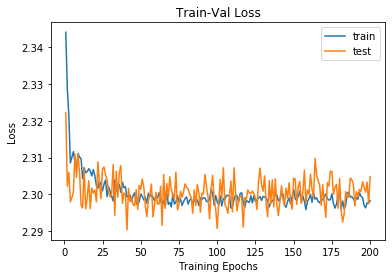

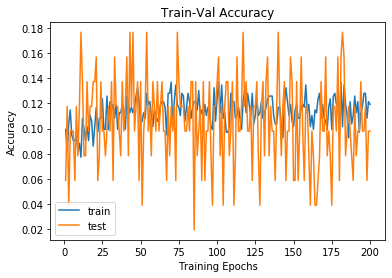

In [20]:
# plot loss and accuracies over epochs
trainutils.plot_loss(loss_hist, metric_hist)